# Semi-supervised Graph Node Classification

This notebook goes through the "Cora" dataset example from [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html). 

## Dependencies

Let's load in the dependencies.

In [13]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch_geometric.utils as utils

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tqdm.auto as tqdm
import numpy as np

## About the **Cora** dataset.

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. [Source.](https://paperswithcode.com/dataset/cora)

In [14]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

First, let us see how many different classes the Cora dataset contains.

In [15]:
dataset.num_classes

7

Let's make sure we have 1433 edge features (i.e. which words each article contains.)

In [16]:
dataset.num_node_features

1433

We can also look at the data matrix.

In [17]:
dataset.data.x.shape

torch.Size([2708, 1433])

How many does the training set, validation set and test set contain?

In [18]:
data = dataset[0]
data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item()

(140, 500, 1000)

# Implementing a Graph Convolutional Networks

Define the GCN.

In [19]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

class RegularizedLoss:
    '''
    Used to calculate the regularized loss.

    Inputs:
        edge_index, edge index of the graph.
        train_mask, train indices that should be used for the training loss.

    '''
    
    def __init__(self, phi, mu, edge_index, train_mask):

        if phi == 'squared_error': 
            self.phi = lambda Zprime, Z : 0.5 * (torch.norm(Zprime - Z, p=2, dim=1) ** 2).sum()
        else:
            raise NotImplementedError()

        #Set the value of mu.
        self.mu = mu

        self.train_mask = train_mask
    
        #Calculate the adjacency matrix.
        A = utils.to_dense_adj(edge_index).squeeze(0)

        #Set N, the number of nodes in the graph.
        self.N, _ = A.shape

        #Calculate the degree matrix, https://github.com/pyg-team/pytorch_geometric/issues/1261#issuecomment-633913984
        D = torch.diag(utils.degree(edge_index[0])) 

        #Calculate the Ahat matrix.
        self.Ahat = torch.linalg.solve(D, A)

        #Use the CrossEntropyLoss. 
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def __call__(self, Z, y):
        '''
        Evaluate the loss function. 
        '''
        N = len(y)
        
        L1 = self.cross_entropy(Z[self.train_mask], y[self.train_mask])

        Zprime = torch.matmul(self.Ahat, Z)

        #Equation (2) in the paper.
        L2 = self.mu * 1/self.N * self.phi(Zprime, Z)

        return L1 + self.mu * L2

Set the device, model, data and optimizer.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [89]:
def get_masks(A,B,dataset):
    N = dataset.data.num_nodes
    y = dataset.data.y
    C = dataset.num_classes

    _, counts = np.unique(dataset.data.y.numpy(), return_counts=True)

    assert not np.any(counts < (A+B)), f'Not enough examples.'

    train_mask = torch.Tensor([False]).repeat(N) 
    val_mask = torch.Tensor([False]).repeat(N)
    test_mask = torch.Tensor([False]).repeat(N)

    for i in range(C):
        num_in_class = (y == i).sum()
        train_mask[torch.where((y == i))[0][:A]] = True
        val_mask[torch.where((y == i))[0][A:A+B]] = True
        test_mask[torch.where((y == i))[0][A+B:num_in_class]] = True
    return train_mask.bool(), val_mask.bool(), test_mask.bool()

train_mask, val_mask, test_mask = get_masks(100, 5, dataset)

Let's train the model.

In [21]:
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = RegularizedLoss(phi = 'squared_error', mu = 1, edge_index = data.edge_index, train_mask = data.train_mask)
model.train()
for epoch in tqdm.tqdm(range(200)):
    optimizer.zero_grad()
    out = model(data)
    
    #loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss = loss_fn(out, data.y)
    
    loss.backward()
    optimizer.step()

100%|██████████| 200/200 [00:07<00:00, 26.94it/s]


Let us also evaluate the model:

In [22]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.5010


Let us also plot the confusion matrix.

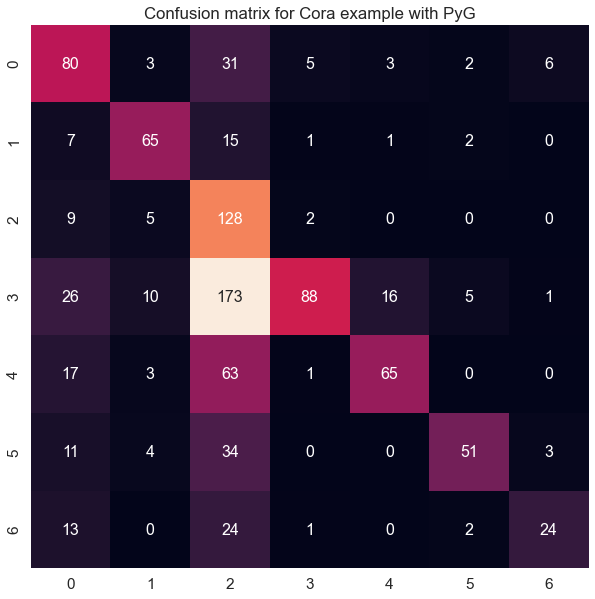

In [23]:
cm = confusion_matrix(y_true = data.y[data.test_mask], y_pred = pred[data.test_mask])
df_cm = pd.DataFrame(cm, range(7), range(7))


plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False) # font size
plt.title('Confusion matrix for Cora example with PyG')
plt.show()

# Implement A Propagation Function

A propagation function. It should take a network and a high-level embedding and return the propagated embedding. That is, given A and Z in the paper, the function calculated $\hat{​​​​​​​A}​​​​​​​Z$ (recall from my presentation last week, that for each node in the network, the propagated embedding of the node is equal to the average of its neighbors embeddings before the propagation (recall that each row in Z is a node embedding, and $\hat{​​​​​​​A}​​​​​​​Z$ is just a matrix way to write the average embedding over the neighbors of each node).
	For this function, it is a good idea to test it on some small examples. Create a network of five nodes and given them one-dimensional node features. Then test that your implementation gives the correct propagated features.